In [3]:
# import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True

In [4]:
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# prepare parameters for model training
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [82]:
model_ft.load_state_dict(torch.load('best_weights.pt', map_location=torch.device('cpu'))) 

<All keys matched successfully>

In [7]:
# model_ft

In [83]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model_ft.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

Total convolution layers: 17


In [84]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

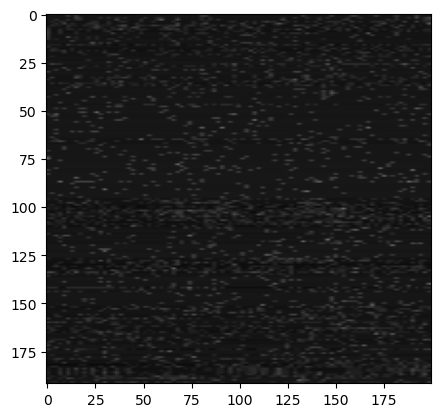

In [85]:
# input_path = 'letter_image_data/viz/i.png'
input_path = 'letter_image_data/val/i/0000.png'

image = Image.open(input_path)
plt.imshow(image)

In [86]:
image.size

(200, 192)

In [87]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 192, 200])
Image shape after: torch.Size([1, 3, 192, 200])


In [88]:
outputs = []
names = []
for layer in conv_layers[0:]:
    print(layer)
    print(image.shape)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([1, 3, 192, 200])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 64, 96, 100])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 64, 96, 100])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 64, 96, 100])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 64, 96, 100])
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([1, 64, 96, 100])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 128, 48, 50])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 128, 48, 50])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
torch.Size([1, 128, 48, 50])
Conv2d(128, 256, kernel_size=(3

In [89]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(96, 100)
(96, 100)
(96, 100)
(96, 100)
(96, 100)
(48, 50)
(48, 50)
(48, 50)
(48, 50)
(24, 25)
(24, 25)
(24, 25)
(24, 25)
(12, 13)
(12, 13)
(12, 13)
(12, 13)


## Layer Output Viz

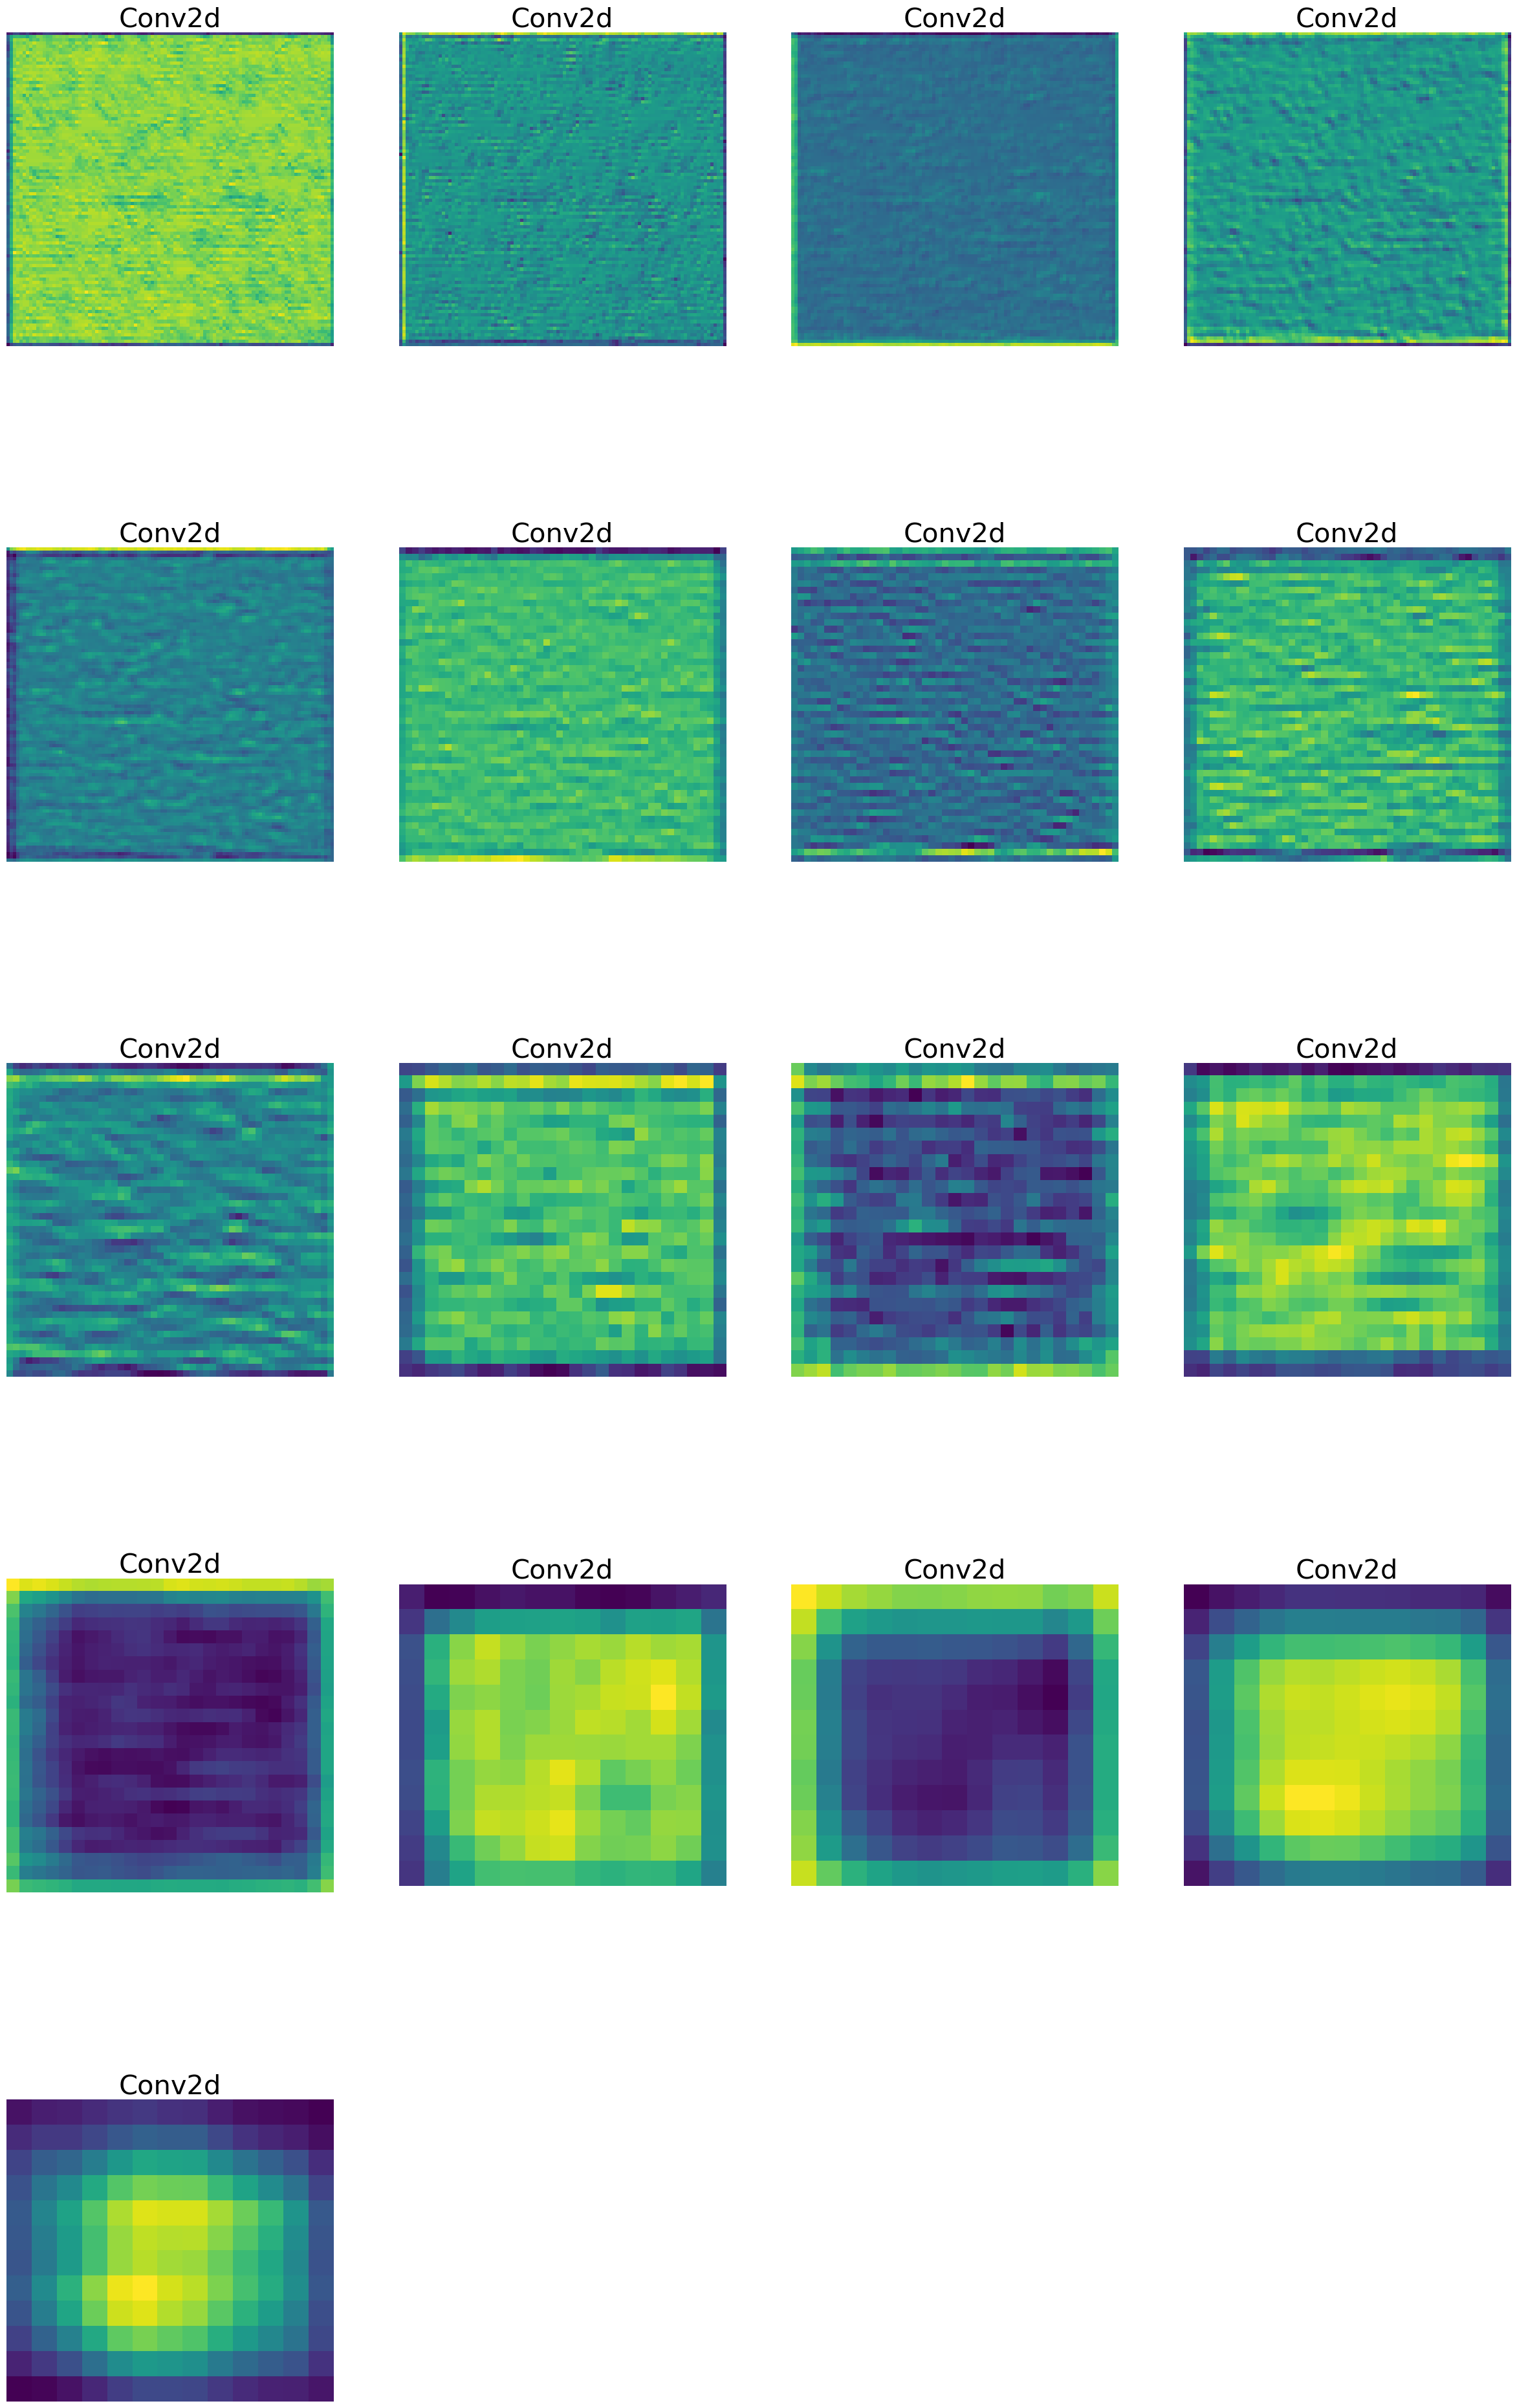

In [90]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
# plt.savefig(str('feature_maps_s.jpg'), bbox_inches='tight')

plt.show()

In [92]:
# fig = plt.figure(figsize=(30, 50))
# for i in range(len(processed)):
#     a = fig.add_subplot(5, 4, i+1)
#     imgplot = plt.imshow(processed[i])
#     a.axis("off")
#     a.set_title(names[i].split('(')[0], fontsize=30)
# # plt.savefig(str('feature_maps_s.jpg'), bbox_inches='tight')

# plt.show()

## Saliency Map

In [93]:
from helpers import *
from baseline import *

In [94]:
def return_saliency_map(image, saliency_map, filename):

    image = image.data.cpu().numpy()
    saliency_map = saliency_map.data.cpu().numpy()

    saliency_map = saliency_map - saliency_map.min()
    saliency_map = saliency_map / saliency_map.max()
    saliency_map = saliency_map.clip(0,1)

    saliency_map = np.uint8(saliency_map * 255).transpose(1, 2, 0)
    # print("saliency_map.shape", saliency_map.shape)
    # saliency_map = cv2.resize(saliency_map, (224,224))

    image = np.uint8(image * 255).transpose(1,2,0)
    # print("image.shape", image.shape)
    # image = cv2.resize(image, (224, 224))

    # Apply JET colormap
    # color_heatmap = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)
    color_heatmap = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)
    
    
    # Combine image with heatmap
    img_with_heatmap = np.float32(color_heatmap) + np.float32(image)
    img_with_heatmap = np.float32(color_heatmap)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    cv2.imwrite(filename, np.uint8(255 * img_with_heatmap))
    # return np.uint8(255 * img_with_heatmap)

    im = Image.open(filename)
    bw_img = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2GRAY)
    
    return bw_img

def save_saliency_map(image, saliency_map, filename):

    # print('save_saliency_map')
    image = image.data.cpu().numpy()
    saliency_map = saliency_map.data.cpu().numpy()

    saliency_map = saliency_map - saliency_map.min()
    saliency_map = saliency_map / saliency_map.max()
    saliency_map = saliency_map.clip(0,1)

    saliency_map = np.uint8(saliency_map * 255).transpose(1, 2, 0)
    # saliency_map = cv2.resize(saliency_map, (224,224))

    image = np.uint8(image * 255).transpose(1,2,0)
    # image = cv2.resize(image, (224, 224))

    # Apply JET colormap
    color_heatmap = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)
    
    # Combine image with heatmap
    img_with_heatmap = np.float32(color_heatmap) + np.float32(image)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    cv2.imwrite(filename, np.uint8(255 * img_with_heatmap))


In [95]:
from os import walk
from tqdm.notebook import tqdm

In [96]:
def avg_saliency_map(letter, input_path, model_ft = model_ft):
    unnormalize = NormalizeInverse(mean = [0.485, 0.456, 0.406],
                           std = [0.229, 0.224, 0.225])

    root_path = input_path+ f'/{letter}/'
    filenames = next(walk(root_path), (None, None, []))[2]  # [] if no file
    output_path = 'saliency/test.jpg'

    saliency_maps = []
    for image_name in tqdm(filenames[:10],desc=f"Processing {letter}"):
        input_path = root_path + image_name
        image = Image.open(input_path)
        image = transform(image)
        # print(f"Image shape before: {image.shape}")
        image = image.unsqueeze(0)
        # print(f"Image shape after: {image.shape}")
        image = image.to(device)
        data = image
        # Track the operations performed on the tensor and compute the gradients automatically during the backward pass.
        data = data.requires_grad_()
        # Compute saliency maps for the input image
        saliency_map = get_saliency(model_ft, data)
        # Save saliency maps
        for i in range(data.size(0)):
            image = unnormalize(data[i].cpu())
            map = return_saliency_map(image, saliency_map[i], output_path) # return saliency map as numpy.ndarray
            saliency_maps.append(map)
            # save_saliency_map(image, saliency_map[i], 'saliency/004.jpg')
        saliency_maps_avg = np.stack(saliency_maps, axis=0).mean(axis=0)

    return saliency_maps_avg

In [131]:
import pandas as pd
from nilearn import plotting

def norm(x):
    # normalize array
    return (x-np.min(x))/(np.max(x)-np.min(x))
def save_saliency_html(map, letter, output_path):
    map_avg = np.mean(map, axis=1)

    x_length = 10
    y_length = 10
    rows = np.linspace(-50, 0, num=x_length)
    cols = np.linspace(-60, 20, num=y_length)
    coordinates = []
    i = 0
    idx = 0
    for r in rows:
        for c in cols:
            if i in [0, 9, 90, 99]: # corner points
                i += 1
                continue
            else:
                i += 1
                val = map_avg[idx]
                coordinates.append([r, c, val])
                idx += 1

    rows = np.linspace(0, 50, num=x_length)
    cols = np.linspace(-60, 20, num=y_length)
    i = 0
    for c in cols:
        for r in rows:
            if i in [0, 9, 90, 99]: # corner points
                i += 1
                continue
            else:
                i += 1
                val = map_avg[idx]
                coordinates.append([r, c, val])
                idx += 1

    coordinates = np.array(coordinates)
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = -(0.115*x)**2 -(0.095*y+1.8)**2 + 74

    map_df = pd.DataFrame({'x': x,
                    'y': y,
                    'z':z,
                    'avg_saliency': coordinates[:, 2]})

    # colors = np.zeros(map_avg.shape)
    # colors = np.where(map_avg>=map_avg.mean(), 'magenta', 'cyan')

    rgbs = [(0,i,1-i) for i in norm(map_avg)]

    dmn_coords = [(map_df.iloc[i, :].x, map_df.iloc[i, :].y, map_df.iloc[i, :].z) for i in range(map_df.shape[0])]
    dmn_coords = [(c[0], c[1], c[2]) for c in dmn_coords]
    # ref: https://nilearn.github.io/dev/modules/generated/nilearn.plotting.view_markers.html
    view = plotting.view_markers(dmn_coords, marker_color=rgbs, marker_size=np.array(map_avg)/3, title=f'Saliency Map of Letter {letter}') 
    # view.open_in_browser() 

    view.save_as_html(output_path) 

In [98]:
letter = 'a'
saliency_maps_avg_a = avg_saliency_map(letter, 'letter_image_data/val')
letter = 'i'
saliency_maps_avg_i = avg_saliency_map(letter, 'letter_image_data/val')
letter = 'r'
saliency_maps_avg_r = avg_saliency_map(letter, 'letter_image_data/val')
letter = 's'
saliency_maps_avg_s = avg_saliency_map(letter, 'letter_image_data/val')

Processing a:   0%|          | 0/10 [00:00<?, ?it/s]

Processing i:   0%|          | 0/10 [00:00<?, ?it/s]

Processing r:   0%|          | 0/10 [00:00<?, ?it/s]

Processing s:   0%|          | 0/10 [00:00<?, ?it/s]

In [132]:
letter = 'a'
save_saliency_html(saliency_maps_avg_a, letter, output_path=f'saliency/avg_saliency_map_{letter}_0424.html')
letter = 's'
save_saliency_html(saliency_maps_avg_s, letter, output_path=f'saliency/avg_saliency_map_{letter}_0424.html')
letter = 'i'
save_saliency_html(saliency_maps_avg_i, letter, output_path=f'saliency/avg_saliency_map_{letter}_0424.html')
letter = 'r'
save_saliency_html(saliency_maps_avg_r, letter, output_path=f'saliency/avg_saliency_map_{letter}_0424.html')

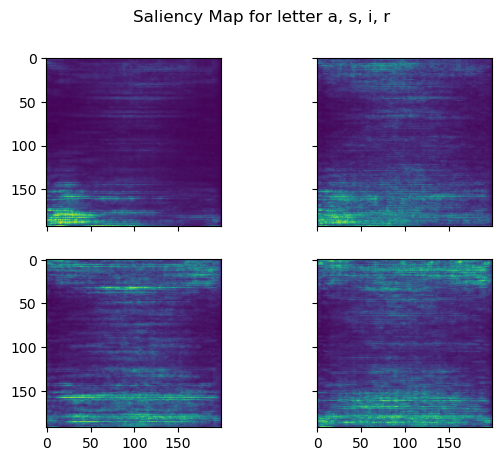

In [100]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Saliency Map for letter a, s, i, r')
ax1.imshow(saliency_maps_avg_a)
ax2.imshow(saliency_maps_avg_s)
ax3.imshow(saliency_maps_avg_i)
ax4.imshow(saliency_maps_avg_r)

for ax in fig.get_axes():
    ax.label_outer()

## Compare with Original Data

In [147]:
def avg_original_img(letter, input_path='letter_image_data/val'):
    root_path = input_path+ f'/{letter}/'
    filenames = next(walk(root_path), (None, None, []))[2]  # [] if no file

    original_imgs = []
    for image_name in tqdm(filenames,desc=f"Processing {letter}"):
        path = root_path + image_name
        original_imgs.append(cv2.cvtColor(np.array(Image.open(path)), cv2.COLOR_BGR2GRAY))

    original_imgs_avg = np.stack(original_imgs, axis=0).mean(axis=0)

    return original_imgs_avg

In [148]:
original_imgs_avg_a = avg_original_img('a')
original_imgs_avg_s = avg_original_img('s')
original_imgs_avg_i = avg_original_img('i')
original_imgs_avg_r = avg_original_img('r')

Processing a:   0%|          | 0/2103 [00:00<?, ?it/s]

Processing s:   0%|          | 0/1720 [00:00<?, ?it/s]

Processing i:   0%|          | 0/1818 [00:00<?, ?it/s]

Processing r:   0%|          | 0/1607 [00:00<?, ?it/s]

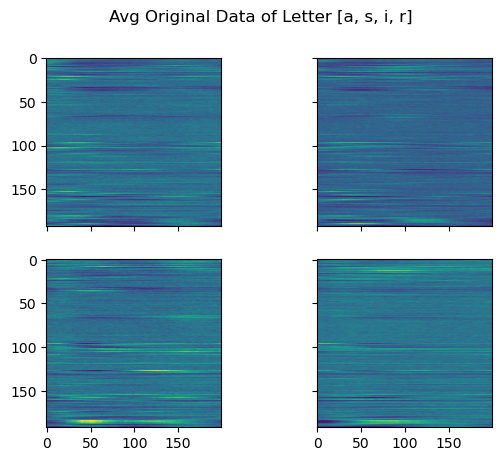

In [149]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Avg Original Data of Letter [a, s, i, r]')
ax1.imshow(original_imgs_avg_a)
ax2.imshow(original_imgs_avg_s)
ax3.imshow(original_imgs_avg_i)
ax4.imshow(original_imgs_avg_r)

for ax in fig.get_axes():
    ax.label_outer()

## Check correct and incorrect predictions

In [183]:
# class order: a, i, r, s
def pred_label_match(input_path='letter_image_data/val'):
    # labels = {'a':0, 'i':1, 'r':2, 's':3}
    labels_reverse = {0:'a', 1:'i', 2:'r', 3:'s'}
    all_letters = ['a', 'i', 'r', 's']
    prediction_dic = {}

    for letter in all_letters:
        root_path = input_path+ f'/{letter}/'
        filenames = next(walk(root_path), (None, None, []))[2]  # [] if no file

        for l in all_letters:
            if l != letter:
                prediction_dic[f'{letter}2{l}'] = []

        for image_name in tqdm(filenames,desc=f"Processing {letter}"):

            path = root_path + image_name
            image = Image.open(path)
            with torch.no_grad():
                output = model_ft(transform(image).unsqueeze(0).to(device))
                pred_idx = torch.max(output, 1).indices.numpy()[0]
            
            pred_letter = labels_reverse[pred_idx]
            if letter != pred_letter:
                prediction_dic[f'{letter}2{pred_letter}'].append(image_name)

    return prediction_dic

In [184]:
prediction_dic = pred_label_match()

Processing a:   0%|          | 0/2103 [00:00<?, ?it/s]

Processing i:   0%|          | 0/1818 [00:00<?, ?it/s]

Processing r:   0%|          | 0/1607 [00:00<?, ?it/s]

Processing s:   0%|          | 0/1720 [00:00<?, ?it/s]

In [186]:
def original_img_per_match(prediction_dic, input_path='letter_image_data/val'):
    
    all_letters = ['a', 'i', 'r', 's']
    im_dic = {}

    for letter in all_letters:
        root_path = input_path+ f'/{letter}/'
        filenames = next(walk(root_path), (None, None, []))[2]  # [] if no file
        other_letters = set(all_letters) - set(letter)
        for l in other_letters:
            im_dic[f'{letter}2{l}'] = []

        for l in other_letters:
            image_names = prediction_dic[f'{letter}2{l}'] # find images that are wrongly predicted
            for image_name in image_names:
                path = root_path + image_name
                im_dic[f'{letter}2{l}'].append(cv2.cvtColor(np.array(Image.open(path)), cv2.COLOR_BGR2GRAY))

    return im_dic

In [187]:
im_match_dic = original_img_per_match(prediction_dic)

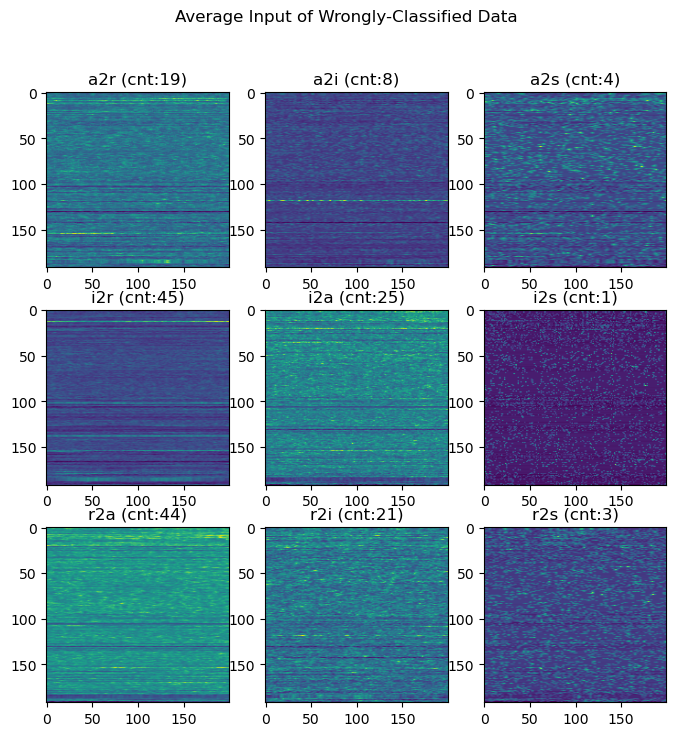

In [271]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

keys = list(im_match_dic.keys())
fig.suptitle('Average Input of Wrongly-Classified Data')
for k, ax in enumerate(axes):
    key = keys[k]
    im_cnt = len(im_match_dic[key])
    avg_im = np.stack(im_match_dic[key], axis=0).mean(axis=0)
    ax.imshow(avg_im)
    ax.set_title(key+f' (cnt:{im_cnt})')

In [216]:
def saliency_map_per_match(prediction_dic, input_path='letter_image_data/val'):
    
    all_letters = ['a', 'i', 'r', 's']
    im_dic = {}
    unnormalize = NormalizeInverse(mean = [0.485, 0.456, 0.406],
                           std = [0.229, 0.224, 0.225])
    output_path = 'saliency/test.jpg'

    for letter in all_letters:
        root_path = input_path+ f'/{letter}/'
        other_letters = set(all_letters) - set(letter)
        for l in other_letters:
            im_dic[f'{letter}2{l}'] = None

        for l in other_letters:
            image_names = prediction_dic[f'{letter}2{l}'] # find images that are wrongly predicted
            saliency_maps = []
            for image_name in image_names:
                path = root_path + image_name
                image = Image.open(path)
                image = transform(image)
                # print(f"Image shape before: {image.shape}")
                image = image.unsqueeze(0)
                # print(f"Image shape after: {image.shape}")
                image = image.to(device)
                data = image
                # Track the operations performed on the tensor and compute the gradients automatically during the backward pass.
                data = data.requires_grad_()
                # Compute saliency maps for the input image
                saliency_map = get_saliency(model_ft, data)
                # Save saliency maps
                image = unnormalize(data.cpu())
                # print(image.detach().numpy().squeeze(0).shape, saliency_map.detach().numpy().squeeze(0).shape)
                map = return_saliency_map(image.squeeze(0), saliency_map.squeeze(0), output_path) # return saliency map as numpy.ndarray
                saliency_maps.append(map)
                saliency_maps_avg = np.stack(saliency_maps, axis=0).mean(axis=0)

            im_dic[f'{letter}2{l}'] = saliency_maps_avg

    return im_dic


In [217]:
saliency_dic = saliency_map_per_match(prediction_dic)

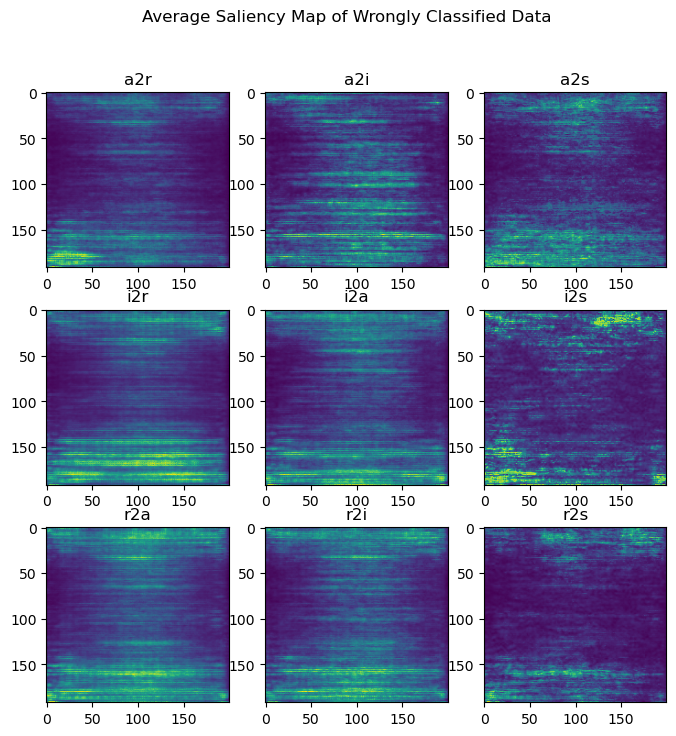

In [272]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

keys = list(saliency_dic.keys())
fig.suptitle('Average Saliency Map of Wrongly Classified Data')
for k, ax in enumerate(axes):
    key = keys[k]
    # im_cnt = len(saliency_dic[key])
    # avg_im = np.stack(im_match_dic[key], axis=0).mean(axis=0)
    ax.imshow(saliency_dic[key])
    ax.set_title(key)

## Hide non-important feature and predict with original model

In [231]:
# np.save('saliency_maps_avg_a.npy', saliency_maps_avg_a)
# np.save('saliency_maps_avg_s.npy', saliency_maps_avg_s)
# np.save('saliency_maps_avg_i.npy', saliency_maps_avg_i)
# np.save('saliency_maps_avg_r.npy', saliency_maps_avg_r)
# arr = np.load('saliency_maps_avg_a.npy')

In [232]:
def important_row(saliency_maps_avg_a, quantile=30):
    x = saliency_maps_avg_a.mean(axis=1)
    pcen=np.percentile(x,quantile,interpolation='nearest')
    mask = np.where(x<pcen, 0, 1)
    return mask

In [260]:
def updated_input_pred(letter, mask, prediction_dic, input_path='letter_image_data/val'):

    all_letters = ['a', 'i', 'r', 's']
    # prediction_dic = {}
    labels_reverse = {0:'a', 1:'i', 2:'r', 3:'s'}

    for l in all_letters:
        if l != letter:
            prediction_dic[f'{letter}2{l}'] = []


    root_path = input_path+ f'/{letter}/'
    filenames = next(walk(root_path), (None, None, []))[2]  # [] if no file

    mask_ = torch.from_numpy(mask.astype(np.float32))
    mask_ = mask_.unsqueeze(-1).expand(torch.Size([3, 192, 200]))

    for image_name in tqdm(filenames,desc=f"Processing {letter}"):
        path = root_path + image_name
        image = Image.open(path)
        with torch.no_grad():
            inp = mask_.mul(transform(image)) # point-wise multiply
            output = model_ft(inp.unsqueeze(0).to(device))
            pred_idx = torch.max(output, 1).indices.numpy()[0]
        
        pred_letter = labels_reverse[pred_idx]
        if letter != pred_letter:
            prediction_dic[f'{letter}2{pred_letter}'].append(image_name)

    return prediction_dic

In [262]:
im_match_dic_update = original_img_per_match(prediction_dic_update)